## DSC 180AB Data Science Capstone
### Replication Project

Team Members: Stephanie Chavez, Benjamin Chen, Sam Horio, Jayson Leach, Natalie Wu

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms . It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 package is available in both Python and R. Documentation is available [here](https://aif360.readthedocs.io/en/v0.2.3/index.html)

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classfier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

# TODO
---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 R=repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [1]:
%%capture output
# silence the stupid aif warnings

# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline

In [2]:
raw_181 = pd.read_csv('data/h181.csv')

#### Apply pre-processing scripts

In [3]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})
    
    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [4]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [48]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings

We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [69]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]
df_panel_19_reduced['RACE'] = df_panel_19_reduced['RACE'].fillna('White')

<ipython-input-69-8b41210dbe0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_19_reduced['RACE'] = df_panel_19_reduced['RACE'].fillna('White')


In [70]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]
df_panel_20_reduced['RACE'] = df_panel_20_reduced['RACE'].fillna('White')

<ipython-input-70-9004f07895b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_20_reduced['RACE'] = df_panel_20_reduced['RACE'].fillna('White')


In [14]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

In [15]:
df_panel_19_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,White,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,White,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005


In [16]:
df_panel_20_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16578,3,65,1,Non-White,1,-1,4,1,3,3,...,2,39.15,64.23,1,1,1,4,1,0,11966.862856
16579,3,57,2,Non-White,1,-1,2,2,3,3,...,2,23.61,48.28,5,3,4,4,1,1,10300.188631
16580,4,40,1,Non-White,1,-1,2,2,3,3,...,2,53.97,52.82,4,0,1,5,1,0,18749.279706
16581,3,55,2,Non-White,5,-1,2,2,3,3,...,1,40.50,61.61,0,0,1,2,2,0,5532.628347
16582,3,21,2,Non-White,5,1,2,2,3,3,...,-1,-1.00,-1.00,-1,-1,4,2,3,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,3,8,1,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,2812.010290
35423,2,30,2,Non-White,5,-1,2,2,3,2,...,2,44.32,28.41,7,2,1,3,1,1,11481.496934
35424,3,32,1,Non-White,1,-1,2,2,3,2,...,2,36.80,61.23,1,0,1,5,1,0,8357.376060
35425,3,32,2,Non-White,1,-1,2,2,2,2,...,2,56.48,47.77,1,0,1,5,1,0,8389.102961


In [20]:
# Identify feature names
# Check for categorical features
feat = ['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
d = [['Region', 'Categorical'], ['Age', 'Numerical'], ['Sex', 'Categorical'], ['Race', 'Categorical'],
     ['Marital Status', 'Categorical'], ['Student Status', 'Categorical'], ['Military Status', 'Categorical'],
     ['Honorable Discharge Status', 'Categorical'], ['Percieved Health Status', 'Categorical'],
     ['Mental Health Status', 'Categorical'], ['High Blood Pressure Diagnosis', 'Categorical'],
     ['Coronary Heart Disease Diagnosis', 'Categorical'], ['Angina Diagnosis', 'Categorical'],
     ['Heart Attack (MI) Diagnosis', 'Categorical'], ['Other Heart Disease Diagnosis', 'Categorical'],
     ['Stroke Diagnosis', 'Categorical'], ['Emphysema Diagnosis', 'Categorical'],
     ['Chronic Bronchitis (> 12 Months) Diagnosis', 'Categorical'], ['High Cholesterol Diagnosis', 'Categorical'],
     ['Cancer Diagnosis', 'Categorical'], ['Diabetes Diagnosis', 'Categorical'],
     ['Joint Pain (> 12 Months) Diagnosis', 'Categorical'], ['Arthritis Diagnosis', 'Categorical'],
     ['Arthritis Type', 'Categorical'], ['Asthma Diagnosis', 'Categorical'], ['ADHD ADD Diagnois', 'Categorical'],
     ['Pregnancy Status', 'Categorical'], ['Limitation in Physical Activity', 'Categorical'],
     ['Limitation in Work, Housework, School', 'Categorical'], ['Social Limitations', 'Categorical'],
     ['Cognitive Limitations', 'Categorical'], ['Serious Difficulty Hearing', 'Categorical'],
     ['Serious Difficulty Seeing with Glasses', 'Categorical'], ['Currently Smoke', 'Categorical'],
     ['Physical Component Summary', 'Numerical'], ['Mental Component Summary', 'Numerical'],
     ['Overall Rating of Feelings 30 Days', 'Categorical'], ['Overall Rating of Feelings 2 Weeks', 'Categorical'],
     ['Employment Status', 'Categorical'], ['Family Income as Percent of Poverty Line', 'Categorical'],
     ['Health Insurance Coverage', 'Categorical'], ['Utilization Based on Number of Trips', 'Categorical'],
     ['Final Person Weight', 'Numerical']]
feature_key = pd.DataFrame(data=d, index=feat, columns = ['Description', 'Data Type'])
feature_key

,Description,Data Type
REGION,Region,Categorical
AGE,Age,Numerical
SEX,Sex,Categorical
RACE,Race,Categorical
MARRY,Marital Status,Categorical
FTSTU,Student Status,Categorical
ACTDTY,Military Status,Categorical
HONRDC,Honorable Discharge Status,Categorical
RTHLTH,Percieved Health Status,Categorical
MNHLTH,Mental Health Status,Categorical


In [71]:
# Summary statistics
df_panel_19_reduced.describe().T

,count,mean,std,min,25%,50%,75%,max
REGION,15830.0,2.825584,1.002033,1.0,2.000000,3.000000,4.000000,4.000000
AGE,15830.0,35.090461,22.475549,0.0,15.000000,33.000000,53.000000,85.000000
SEX,15830.0,1.521162,0.499568,1.0,1.000000,2.000000,2.000000,2.000000
MARRY,15830.0,3.661213,2.121255,1.0,1.000000,5.000000,6.000000,10.000000
FTSTU,15830.0,-0.720088,0.910025,-1.0,-1.000000,-1.000000,-1.000000,3.000000
ACTDTY,15830.0,2.581364,0.758747,1.0,2.000000,2.000000,3.000000,4.000000
HONRDC,15830.0,2.224889,0.512242,1.0,2.000000,2.000000,3.000000,4.000000
RTHLTH,15830.0,2.187871,1.054677,-1.0,1.000000,2.000000,3.000000,5.000000
MNHLTH,15830.0,1.993051,1.002657,-1.0,1.000000,2.000000,3.000000,5.000000
HIBPDX,15830.0,0.918067,1.267763,-1.0,-1.000000,1.000000,2.000000,2.000000


In [72]:
df_panel_20_reduced.describe().T

,count,mean,std,min,25%,50%,75%,max
REGION,17570.0,2.778201,1.016363,1.0,2.000000,3.000000,4.00000,4.000000
AGE,17570.0,35.396187,22.662113,0.0,15.000000,34.000000,53.00000,85.000000
SEX,17570.0,1.519465,0.499635,1.0,1.000000,2.000000,2.00000,2.000000
MARRY,17570.0,3.626010,2.148104,1.0,1.000000,5.000000,6.00000,10.000000
FTSTU,17570.0,-0.718668,0.908419,-1.0,-1.000000,-1.000000,-1.00000,3.000000
ACTDTY,17570.0,2.594764,0.767781,1.0,2.000000,2.000000,3.00000,4.000000
HONRDC,17570.0,2.223734,0.518731,1.0,2.000000,2.000000,3.00000,4.000000
RTHLTH,17570.0,2.167103,1.084599,-1.0,1.000000,2.000000,3.00000,5.000000
MNHLTH,17570.0,1.942971,1.012665,-1.0,1.000000,2.000000,3.00000,5.000000
HIBPDX,17570.0,0.922595,1.268244,-1.0,-1.000000,1.000000,2.00000,2.000000


In [22]:
# Shapes
df_panel_19_reduced.shape, df_panel_20_reduced.shape

((15830, 43), (17570, 43))

#### 2.3 Outlier Detection and Handling

In [23]:
# # Null handling

In [76]:
df_panel_19_reduced.isnull().sum()

REGION         0
AGE            0
SEX            0
RACE           0
MARRY          0
FTSTU          0
ACTDTY         0
HONRDC         0
RTHLTH         0
MNHLTH         0
HIBPDX         0
CHDDX          0
ANGIDX         0
MIDX           0
OHRTDX         0
STRKDX         0
EMPHDX         0
CHBRON         0
CHOLDX         0
CANCERDX       0
DIABDX         0
JTPAIN         0
ARTHDX         0
ARTHTYPE       0
ASTHDX         0
ADHDADDX       0
PREGNT         0
WLKLIM         0
ACTLIM         0
SOCLIM         0
COGLIM         0
DFHEAR42       0
DFSEE42        0
ADSMOK42       0
PCS42          0
MCS42          0
K6SUM42        0
PHQ242         0
EMPST          0
POVCAT         0
INSCOV         0
UTILIZATION    0
PERWT15F       0
dtype: int64

In [77]:
df_panel_20_reduced.isnull().sum()

REGION         0
AGE            0
SEX            0
RACE           0
MARRY          0
FTSTU          0
ACTDTY         0
HONRDC         0
RTHLTH         0
MNHLTH         0
HIBPDX         0
CHDDX          0
ANGIDX         0
MIDX           0
OHRTDX         0
STRKDX         0
EMPHDX         0
CHBRON         0
CHOLDX         0
CANCERDX       0
DIABDX         0
JTPAIN         0
ARTHDX         0
ARTHTYPE       0
ASTHDX         0
ADHDADDX       0
PREGNT         0
WLKLIM         0
ACTLIM         0
SOCLIM         0
COGLIM         0
DFHEAR42       0
DFSEE42        0
ADSMOK42       0
PCS42          0
MCS42          0
K6SUM42        0
PHQ242         0
EMPST          0
POVCAT         0
INSCOV         0
UTILIZATION    0
PERWT15F       0
dtype: int64

#### 2.4 Correlation Analysis

In [24]:
# Visualizations to identify potential protected groups (demographics with relative high medical utilizations)

In [81]:
# there is something horrifyingly wrong
df_panel_19_reduced[df_panel_19_reduced['RACE'] == 'Non-White']['UTILIZATION'].value_counts()

Series([], Name: count, dtype: int64)

In [82]:
# there is something horrifyingly wrong
df_panel_19_reduced[df_panel_19_reduced['RACE'] != 'Non-White']['UTILIZATION'].value_counts()

UTILIZATION
0    13112
1     2718
Name: count, dtype: int64

<ipython-input-25-5db4b68cfcf3>:8: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.catplot(data=util_data_1, kind="bar", x="UTILIZATION", y="COUNT", hue="RACE", palette=['tomato', 'deepskyblue'])


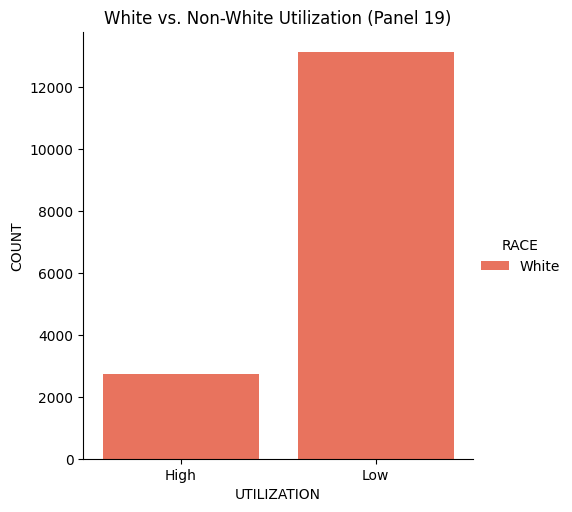

In [25]:
# identified disparity in occurance of high utilization with categories of race
df_panel_19_reduced[df_panel_19_reduced['RACE'] == 'Non-White']['UTILIZATION'].value_counts(), df_panel_19_reduced[df_panel_19_reduced['RACE'] != 'Non-White']['UTILIZATION'].value_counts()
# select and modify useful columns
util_data_1 = df_panel_19_reduced[['RACE', 'UTILIZATION', 'AGE']].copy().rename(columns={'AGE': 'COUNT'})
util_data_1['UTILIZATION'] = util_data_1['UTILIZATION'].replace([0,1], ['Low', 'High'])
util_data_1 = util_data_1.groupby(['RACE', 'UTILIZATION']).count().reset_index()
# visualize
sns.catplot(data=util_data_1, kind="bar", x="UTILIZATION", y="COUNT", hue="RACE", palette=['tomato', 'deepskyblue'])
plt.title('White vs. Non-White Utilization (Panel 19)')
plt.show()

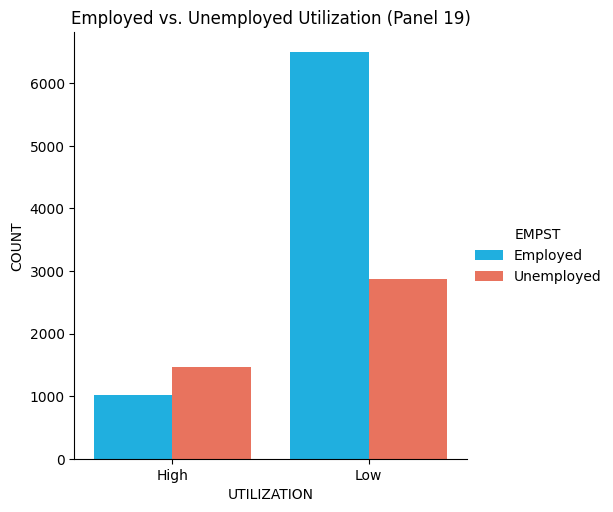

In [26]:
# identified disparity in occurance of high utilization with categories of employment
# -1 inapplicable, 1 employed, 2 job to return, 3 job during period, 4 unemployed
df_panel_19_reduced[df_panel_19_reduced['EMPST'] == 4]['UTILIZATION'].value_counts(), df_panel_19_reduced[(df_panel_19_reduced['EMPST'] != 4) & (df_panel_19_reduced['EMPST'] != -1)]['UTILIZATION'].value_counts()
# select and modify useful columns, remove inapplicables
util_data_2 = df_panel_19_reduced[['EMPST', 'UTILIZATION', 'AGE']].copy().rename(columns={'AGE': 'COUNT'})
util_data_2 = util_data_2[util_data_2['EMPST'] != -1]
util_data_2['EMPST'] = util_data_2['EMPST'].replace([1,2,3], 'Employed').replace(4, 'Unemployed')
util_data_2['UTILIZATION'] = util_data_2['UTILIZATION'].replace([0,1], ['Low', 'High'])
util_data_2 = util_data_2.groupby(['EMPST', 'UTILIZATION']).count().reset_index()
# visualize
sns.catplot(data=util_data_2, kind="bar", x="UTILIZATION", y="COUNT", hue="EMPST", palette=['deepskyblue', 'tomato'])
plt.title('Employed vs. Unemployed Utilization (Panel 19)')
plt.show()

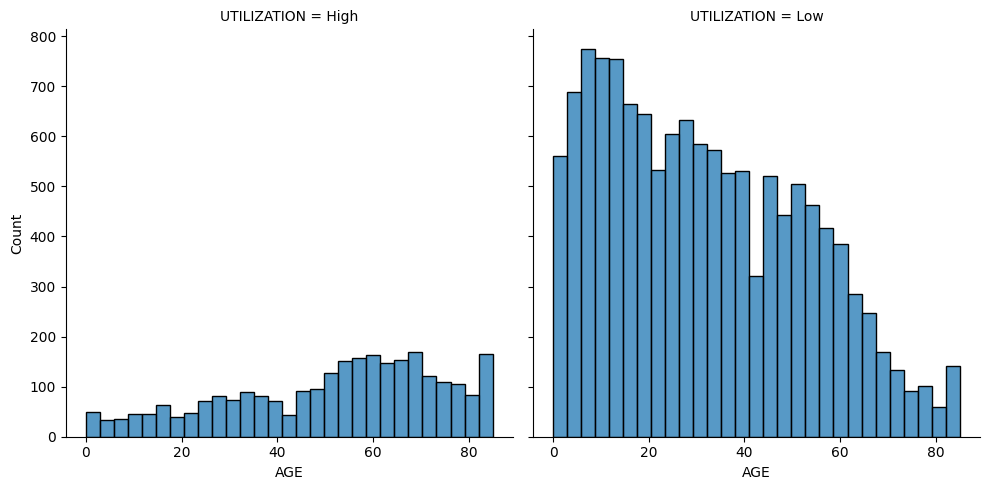

In [27]:
# identified disparity in occurance of high utilization with age
# select and modify useful columns, remove inapplicables
util_data_3 = df_panel_19_reduced.copy()
util_data_3['UTILIZATION'] = util_data_3['UTILIZATION'].replace([0,1], ['Low', 'High'])
# visualize
sns.displot(util_data_3, x="AGE", col="UTILIZATION")
plt.show()

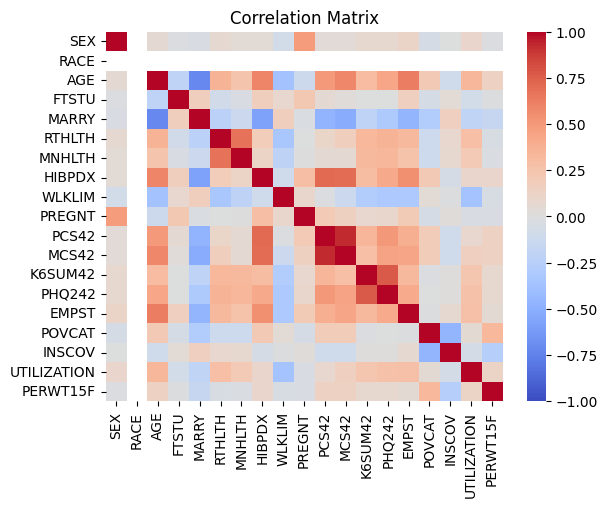

In [28]:
# Correlation plots
# not sure of which columns we all want to use yet but these are the ones I would keep in features_to_keep.
# Looking at the full correlation matrix for all the columns, a lot of the ones left out are highly correlated to a
# column included. Feel free to look at the full matrix for context.
cor = df_panel_19_reduced[['SEX', 'RACE', 'AGE', 'FTSTU', 'MARRY', 'RTHLTH', 'MNHLTH', 'HIBPDX', 'WLKLIM', 'PREGNT', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV', 'UTILIZATION', 'PERWT15F']].replace(['Non-White', 'White'],[0, 1]).corr()
hm = sns.heatmap(cor, vmin=-1, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 2.5 Other analysis

In [ ]:
# Enter here

-----
End of Exploratory Data Analysis

_Items below will be updated as course progress_

### [3.](#Table-of-Contents) Model Development 

### [4.](#Table-of-Contents) Model Evaluation

### [5.](#Table-of-Contents) Bias Mitigation

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion